In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import os

# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

In [ ]:
# Set paths (adjusted to match your directory)
data_dir = '.'  # current directory
metadata_path = os.path.join(data_dir, 'HAM10000_metadata.csv')
images_dir_1 = os.path.join(data_dir, 'HAM10000_images_part_1')
images_dir_2 = os.path.join(data_dir, 'HAM10000_images_part_2')

# Load metadata
df = pd.read_csv(metadata_path)

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nClass Distribution:")
print(df['dx'].value_counts())

print("\nMissing Values:")
print(df.isnull().sum())

In [ ]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
df['dx'].value_counts().plot(kind='bar')
plt.title('Distribution of Skin Cancer Types')
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Class labels explanation
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

print("\nLesion Types:")
for key, value in lesion_type_dict.items():
    count = len(df[df['dx'] == key])
    print(f"{key}: {value} - {count} images")

In [ ]:
# Function to get full image path
def get_image_path(image_id):
    path_1 = os.path.join(images_dir_1, image_id + '.jpg')
    path_2 = os.path.join(images_dir_2, image_id + '.jpg')
    
    if os.path.exists(path_1):
        return path_1
    elif os.path.exists(path_2):
        return path_2
    else:
        return None

# Add image path to dataframe
df['path'] = df['image_id'].apply(get_image_path)

# Check if all images are found
print(f"Images found: {df['path'].notna().sum()} / {len(df)}")
print(f"Missing images: {df['path'].isna().sum()}")

# Remove rows with missing images
df = df.dropna(subset=['path'])

In [ ]:
# Display sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i, lesion_type in enumerate(df['dx'].unique()):
    sample_img_path = df[df['dx'] == lesion_type]['path'].iloc[0]
    img = Image.open(sample_img_path)
    axes[i].imshow(img)
    axes[i].set_title(f'{lesion_type}: {lesion_type_dict[lesion_type]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Load and preprocess images
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0  # Normalize to [0, 1]
    return img

print("Loading images... This may take a few minutes...")

# Load all images
X = np.array([load_and_preprocess_image(path) for path in df['path']])
print(f"Images loaded: {X.shape}")

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['dx'])
y = to_categorical(y)  # One-hot encoding

print(f"Labels encoded: {y.shape}")
print(f"Classes: {label_encoder.classes_}")

In [ ]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

In [14]:
# Data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [ ]:
# Build CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
num_classes = len(label_encoder.classes_)

model = create_cnn_model(input_shape, num_classes)

# Display model architecture
model.summary()

In [10]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_skin_cancer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [ ]:
# Train the model
BATCH_SIZE = 32
EPOCHS = 100

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,  
    verbose=1
)

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, 
                          target_names=label_encoder.classes_))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# Save the final model
model.save('skin_cancer_cnn_model.h5')
print("Model saved successfully!")

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved!")

In [ ]:
# Function to predict on a single image
def predict_skin_cancer(image_path, model, label_encoder):
    # Load and preprocess image
    img = load_and_preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    
    # Predict
    prediction = model.predict(img)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = label_encoder.classes_[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx] * 100
    
    # Display result
    plt.figure(figsize=(6, 6))
    display_img = Image.open(image_path)
    plt.imshow(display_img)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

# Test on a random image from test set
test_idx = np.random.randint(0, len(X_test))
test_image_path = df.iloc[test_idx]['path']
predicted_class, confidence = predict_skin_cancer(test_image_path, model, label_encoder)

print(f"\nPredicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

TEST MODELS ACCURACY



In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_score, 
                             recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [7]:
# ============================================================================
# CELL 2: Configuration
# ============================================================================

# Model paths - UPDATE THESE
MODEL1_PATH = 'skin_cancer_cnn_model.h5'  # First model
MODEL2_PATH = 'skin_cancer_cnn_old_one.h5'  # Second model

# Dataset paths
DATA_DIR = '.'
METADATA_PATH = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')
IMAGES_DIR_1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMAGES_DIR_2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2')

# Model configuration - UPDATE THESE
IMG_SIZE = (128, 128)  # Match your model's input size (224, 128, or 299)
USE_BINARY = False     # True for binary (cancer/no-cancer), False for 7-class
NUM_CLASSES = 7        # HAM10000 has 7 classes
TEST_SIZE = 0.2        # Percentage of data for testing
RANDOM_STATE = 42      # For reproducibility

print("="*60)
print("CONFIGURATION")
print("="*60)
print(f"Model 1: {MODEL1_PATH}")
print(f"Model 2: {MODEL2_PATH}")
print(f"Image Size: {IMG_SIZE}")
print(f"Classification Type: {'Binary' if USE_BINARY else 'Multi-class (7 classes)'}")
print(f"Test Size: {TEST_SIZE*100}%")
print("="*60)

CONFIGURATION
Model 1: skin_cancer_cnn_model.h5
Model 2: skin_cancer_cnn_old_one.h5
Image Size: (128, 128)
Classification Type: Multi-class (7 classes)
Test Size: 20.0%


In [8]:
# ============================================================================
# CELL 3: Helper Functions
# ============================================================================

def load_image(image_id, img_size):
    """Load and preprocess image from HAM10000 dataset"""
    img_path_1 = os.path.join(IMAGES_DIR_1, f"{image_id}.jpg")
    img_path_2 = os.path.join(IMAGES_DIR_2, f"{image_id}.jpg")
    
    if os.path.exists(img_path_1):
        img_path = img_path_1
    elif os.path.exists(img_path_2):
        img_path = img_path_2
    else:
        return None
    
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array


def prepare_data():
    """Load and prepare HAM10000 dataset"""
    print("="*60)
    print("LOADING HAM10000 DATASET")
    print("="*60)
    
    # Load metadata
    df = pd.read_csv(METADATA_PATH)
    print(f"\nTotal images: {len(df)}")
    print(f"\nClass distribution:")
    print(df['dx'].value_counts())
    
    # Prepare labels
    if USE_BINARY:
        # Binary: malignant (mel, bcc) vs benign (others)
        df['label'] = df['dx'].apply(lambda x: 1 if x in ['mel', 'bcc'] else 0)
        print("\n" + "-"*60)
        print("Using BINARY classification: Malignant vs Benign")
        print("-"*60)
        print(f"Malignant (mel, bcc): {df['label'].sum()}")
        print(f"Benign (others): {len(df) - df['label'].sum()}")
    else:
        # Multi-class: encode all 7 classes
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['dx'])
        print("\n" + "-"*60)
        print("Using MULTI-CLASS classification (7 classes)")
        print("-"*60)
        print("\nClass encoding:")
        for cls, idx in zip(le.classes_, le.transform(le.classes_)):
            count = len(df[df['dx'] == cls])
            print(f"  {idx}: {cls} ({count} images)")
    
    # Split data
    train_df, test_df = train_test_split(
        df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['label']
    )
    print(f"\n" + "-"*60)
    print(f"Dataset split (random_state={RANDOM_STATE}):")
    print(f"  Training samples: {len(train_df)}")
    print(f"  Testing samples: {len(test_df)}")
    print("-"*60)
    
    # Load test images
    print("\nLoading test images (this may take a moment)...")
    X_test = []
    y_test = []
    
    loaded_count = 0
    for idx, row in test_df.iterrows():
        img = load_image(row['image_id'], IMG_SIZE)
        if img is not None:
            X_test.append(img)
            y_test.append(row['label'])
            loaded_count += 1
            if loaded_count % 500 == 0:
                print(f"  Loaded {loaded_count}/{len(test_df)} images...")
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # Convert labels for multi-class
    if not USE_BINARY and NUM_CLASSES > 2:
        y_test = to_categorical(y_test, NUM_CLASSES)
    
    print(f"\n✓ Data loading complete!")
    print(f"  Test data shape: {X_test.shape}")
    print(f"  Test labels shape: {y_test.shape}")
    print("="*60 + "\n")
    
    return X_test, y_test


def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate a single model and return comprehensive metrics"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name}")
    print(f"{'='*60}")
    
    # Get predictions
    print("Generating predictions...")
    y_pred_proba = model.predict(X_test, verbose=0)
    
    if USE_BINARY:
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_true = y_test.flatten() if len(y_test.shape) > 1 else y_test
    else:
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    
    # Calculate basic metrics
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\n📊 Basic Metrics:")
    print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  Loss: {test_loss:.4f}")
    
    # Classification report
    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"🔢 Confusion Matrix:")
    print(cm)
    
    # Calculate additional metrics
    if USE_BINARY:
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        print(f"\n🏥 Clinical Metrics:")
        print(f"  Sensitivity (Recall): {sensitivity:.4f} - Ability to detect cancer")
        print(f"  Specificity: {specificity:.4f} - Ability to identify non-cancer")
        print(f"  Precision: {precision:.4f} - Accuracy of cancer predictions")
        print(f"  F1-Score: {f1:.4f}")
        
        # ROC-AUC
        auc = roc_auc_score(y_true, y_pred_proba)
        print(f"  ROC-AUC Score: {auc:.4f}")
        
        return {
            'accuracy': test_accuracy,
            'loss': test_loss,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1_score': f1,
            'auc': auc,
            'confusion_matrix': cm,
            'y_pred_proba': y_pred_proba.flatten(),
            'y_pred': y_pred,
            'y_true': y_true
        }
    else:
        # Multi-class metrics
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        print(f"\n📈 Weighted Metrics:")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        
        return {
            'accuracy': test_accuracy,
            'loss': test_loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'y_pred': y_pred,
            'y_true': y_true
        }


def plot_comparison(results1, results2, model1_name="Model 1", model2_name="Model 2"):
    """Create comprehensive visualization comparing both models"""
    
    if USE_BINARY:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Metrics comparison
        metrics = ['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-Score']
        model1_scores = [
            results1['accuracy'], results1['precision'],
            results1['sensitivity'], results1['specificity'], results1['f1_score']
        ]
        model2_scores = [
            results2['accuracy'], results2['precision'],
            results2['sensitivity'], results2['specificity'], results2['f1_score']
        ]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        bars1 = axes[0, 0].bar(x - width/2, model1_scores, width, 
                               label=model1_name, alpha=0.8, color='#3498db')
        bars2 = axes[0, 0].bar(x + width/2, model2_scores, width, 
                               label=model2_name, alpha=0.8, color='#2ecc71')
        
        axes[0, 0].set_xlabel('Metrics', fontsize=12, fontweight='bold')
        axes[0, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
        axes[0, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
        axes[0, 0].legend(fontsize=11, loc='lower right')
        axes[0, 0].grid(axis='y', alpha=0.3)
        axes[0, 0].set_ylim([0, 1.1])
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                              f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 2. Confusion Matrix - Model 1
        sns.heatmap(results1['confusion_matrix'], annot=True, fmt='d', 
                    cmap='Blues', ax=axes[0, 1], cbar_kws={'label': 'Count'},
                    annot_kws={'size': 14})
        axes[0, 1].set_title(f'{model1_name} - Confusion Matrix', 
                            fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('True Label', fontsize=12)
        axes[0, 1].set_xlabel('Predicted Label', fontsize=12)
        axes[0, 1].set_xticklabels(['Benign', 'Malignant'], fontsize=11)
        axes[0, 1].set_yticklabels(['Benign', 'Malignant'], fontsize=11)
        
        # 3. Confusion Matrix - Model 2
        sns.heatmap(results2['confusion_matrix'], annot=True, fmt='d', 
                    cmap='Greens', ax=axes[1, 0], cbar_kws={'label': 'Count'},
                    annot_kws={'size': 14})
        axes[1, 0].set_title(f'{model2_name} - Confusion Matrix', 
                            fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('True Label', fontsize=12)
        axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
        axes[1, 0].set_xticklabels(['Benign', 'Malignant'], fontsize=11)
        axes[1, 0].set_yticklabels(['Benign', 'Malignant'], fontsize=11)
        
        # 4. ROC Curves
        fpr1, tpr1, _ = roc_curve(results1['y_true'], results1['y_pred_proba'])
        fpr2, tpr2, _ = roc_curve(results2['y_true'], results2['y_pred_proba'])
        
        axes[1, 1].plot(fpr1, tpr1, label=f'{model1_name} (AUC={results1["auc"]:.3f})', 
                       linewidth=2.5, color='#3498db')
        axes[1, 1].plot(fpr2, tpr2, label=f'{model2_name} (AUC={results2["auc"]:.3f})', 
                       linewidth=2.5, color='#2ecc71')
        axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)
        axes[1, 1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
        axes[1, 1].set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=11, loc='lower right')
        axes[1, 1].grid(alpha=0.3)
        
    else:
        # Multi-class visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Metrics comparison
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        model1_scores = [
            results1['accuracy'], results1['precision'],
            results1['recall'], results1['f1_score']
        ]
        model2_scores = [
            results2['accuracy'], results2['precision'],
            results2['recall'], results2['f1_score']
        ]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        bars1 = axes[0, 0].bar(x - width/2, model1_scores, width, 
                               label=model1_name, alpha=0.8, color='#3498db')
        bars2 = axes[0, 0].bar(x + width/2, model2_scores, width, 
                               label=model2_name, alpha=0.8, color='#2ecc71')
        
        axes[0, 0].set_xlabel('Metrics', fontsize=12, fontweight='bold')
        axes[0, 0].set_ylabel('Score', fontsize=12, fontweight='bold')
        axes[0, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(metrics)
        axes[0, 0].legend(fontsize=11, loc='lower right')
        axes[0, 0].grid(axis='y', alpha=0.3)
        axes[0, 0].set_ylim([0, 1.1])
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                              f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        # 2. Confusion Matrix - Model 1
        sns.heatmap(results1['confusion_matrix'], annot=True, fmt='d', 
                    cmap='Blues', ax=axes[0, 1], cbar_kws={'label': 'Count'},
                    annot_kws={'size': 10})
        axes[0, 1].set_title(f'{model1_name} - Confusion Matrix', 
                            fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('True Label', fontsize=12)
        axes[0, 1].set_xlabel('Predicted Label', fontsize=12)
        
        # 3. Confusion Matrix - Model 2
        sns.heatmap(results2['confusion_matrix'], annot=True, fmt='d', 
                    cmap='Greens', ax=axes[1, 0], cbar_kws={'label': 'Count'},
                    annot_kws={'size': 10})
        axes[1, 0].set_title(f'{model2_name} - Confusion Matrix', 
                            fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('True Label', fontsize=12)
        axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
        
        # 4. Loss comparison
        bars = axes[1, 1].bar([model1_name, model2_name], 
                             [results1['loss'], results2['loss']], 
                             color=['#3498db', '#2ecc71'], alpha=0.8, width=0.6)
        axes[1, 1].set_ylabel('Test Loss', fontsize=12, fontweight='bold')
        axes[1, 1].set_title('Loss Comparison', fontsize=14, fontweight='bold')
        axes[1, 1].grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.4f}', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved as 'model_comparison.png'")
    plt.show()


def print_final_recommendation(results1, results2):
    """Print final comparison and recommendation"""
    print("\n" + "="*60)
    print("🎯 FINAL COMPARISON & RECOMMENDATION")
    print("="*60)
    
    print(f"\nModel 1 Accuracy: {results1['accuracy']:.4f} ({results1['accuracy']*100:.2f}%)")
    print(f"Model 2 Accuracy: {results2['accuracy']:.4f} ({results2['accuracy']*100:.2f}%)")
    
    if results1['accuracy'] > results2['accuracy']:
        diff = (results1['accuracy'] - results2['accuracy']) * 100
        print(f"\n✓ Model 1 has better accuracy by {diff:.2f}%")
        better_model = "Model 1"
    else:
        diff = (results2['accuracy'] - results1['accuracy']) * 100
        print(f"\n✓ Model 2 has better accuracy by {diff:.2f}%")
        better_model = "Model 2"
    
    if USE_BINARY:
        print("\n" + "-"*60)
        print("🏥 CLINICAL IMPORTANCE (Skin Cancer Detection):")
        print("-"*60)
        print(f"\nSensitivity (Detecting actual cancer cases):")
        print(f"  Model 1: {results1['sensitivity']:.4f} ({results1['sensitivity']*100:.1f}%)")
        print(f"  Model 2: {results2['sensitivity']:.4f} ({results2['sensitivity']*100:.1f}%)")
        
        if results1['sensitivity'] > results2['sensitivity']:
            print(f"  → Model 1 is better at catching cancer cases ✓")
            clinical_choice = "Model 1"
        else:
            print(f"  → Model 2 is better at catching cancer cases ✓")
            clinical_choice = "Model 2"
        
        print(f"\nSpecificity (Avoiding false alarms):")
        print(f"  Model 1: {results1['specificity']:.4f} ({results1['specificity']*100:.1f}%)")
        print(f"  Model 2: {results2['specificity']:.4f} ({results2['specificity']*100:.1f}%)")
        
        print(f"\nROC-AUC Score (Overall discriminative ability):")
        print(f"  Model 1: {results1['auc']:.4f}")
        print(f"  Model 2: {results2['auc']:.4f}")
        
        print("\n" + "-"*60)
        print("💡 FINAL RECOMMENDATION:")
        print("-"*60)
        if better_model == clinical_choice:
            print(f"✓✓ {better_model} is RECOMMENDED")
            print(f"   (Best in both accuracy AND sensitivity)")
        else:
            print(f"⚠️  IMPORTANT: For medical diagnosis, sensitivity is crucial!")
            print(f"   • {clinical_choice} has better sensitivity (catches more cancer)")
            print(f"   • {better_model} has better overall accuracy")
            print(f"\n   🎯 RECOMMENDED: {clinical_choice}")
            print(f"      (Prioritizing patient safety - fewer missed cancer cases)")
    else:
        print("\n" + "-"*60)
        print(f"💡 RECOMMENDATION: {better_model}")
        print("-"*60)
    
    print("\n" + "="*60)

print("✓ Helper functions defined successfully!")


✓ Helper functions defined successfully!


In [9]:
# ============================================================================
# CELL 4: Load Models
# ============================================================================

print("\n" + "="*60)
print("🤖 LOADING MODELS")
print("="*60)

try:
    model1 = keras.models.load_model(MODEL1_PATH)
    print(f"✓ Model 1 loaded successfully: {MODEL1_PATH}")
    print(f"  Input shape: {model1.input_shape}")
    print(f"  Output shape: {model1.output_shape}")
except Exception as e:
    print(f"✗ Error loading Model 1: {e}")
    raise

try:
    model2 = keras.models.load_model(MODEL2_PATH)
    print(f"✓ Model 2 loaded successfully: {MODEL2_PATH}")
    print(f"  Input shape: {model2.input_shape}")
    print(f"  Output shape: {model2.output_shape}")
except Exception as e:
    print(f"✗ Error loading Model 2: {e}")
    raise

print("="*60)


🤖 LOADING MODELS


✓ Model 1 loaded successfully: skin_cancer_cnn_model.h5
  Input shape: (None, 128, 128, 3)
  Output shape: (None, 7)


✓ Model 2 loaded successfully: skin_cancer_cnn_old_one.h5
  Input shape: (None, 128, 128, 3)
  Output shape: (None, 7)


In [10]:
# ============================================================================
# CELL 5: Prepare Test Data
# ============================================================================

X_test, y_test = prepare_data()


LOADING HAM10000 DATASET

Total images: 10015

Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

------------------------------------------------------------
Using MULTI-CLASS classification (7 classes)
------------------------------------------------------------

Class encoding:
  0: akiec (327 images)
  1: bcc (514 images)
  2: bkl (1099 images)
  3: df (115 images)
  4: mel (1113 images)
  5: nv (6705 images)
  6: vasc (142 images)

------------------------------------------------------------
Dataset split (random_state=42):
  Training samples: 8012
  Testing samples: 2003
------------------------------------------------------------

Loading test images (this may take a moment)...
  Loaded 500/2003 images...
  Loaded 1000/2003 images...
  Loaded 1500/2003 images...
  Loaded 2000/2003 images...

✓ Data loading complete!
  Test data shape: (2003, 128, 128, 3)
  Test labels shape: (2003, 7

In [11]:
# ============================================================================
# CELL 6: Evaluate Model 1
# ============================================================================

results1 = evaluate_model(model1, X_test, y_test, "Model 1")


EVALUATING Model 1
Generating predictions...

📊 Basic Metrics:
  Accuracy: 0.7489 (74.89%)
  Loss: 0.6982

📋 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.20      0.24        65
           1       0.47      0.45      0.46       103
           2       0.47      0.35      0.40       220
           3       0.00      0.00      0.00        23
           4       0.56      0.39      0.46       223
           5       0.83      0.95      0.89      1341
           6       0.33      0.04      0.06        28

    accuracy                           0.75      2003
   macro avg       0.42      0.34      0.36      2003
weighted avg       0.71      0.75      0.72      2003

🔢 Confusion Matrix:
[[  13   20   13    0    7   12    0]
 [   8   46   20    0    6   22    1]
 [  10   13   76    0   28   93    0]
 [   0    8    6    0    2    7    0]
 [   6    0   18    0   88  111    0]
 [   3   10   27    0   24 1276    1]
 [   4    1  

In [12]:
# ============================================================================
# CELL 7: Evaluate Model 2
# ============================================================================

results2 = evaluate_model(model2, X_test, y_test, "Model 2")




EVALUATING Model 2
Generating predictions...

📊 Basic Metrics:
  Accuracy: 0.7848 (78.48%)
  Loss: 0.5673

📋 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        65
           1       0.81      0.50      0.62       103
           2       0.58      0.52      0.55       220
           3       1.00      0.04      0.08        23
           4       0.56      0.34      0.42       223
           5       0.84      0.95      0.89      1341
           6       0.83      0.68      0.75        28

    accuracy                           0.78      2003
   macro avg       0.73      0.51      0.54      2003
weighted avg       0.77      0.78      0.77      2003

🔢 Confusion Matrix:
[[  33    2   11    0    4   15    0]
 [  13   52   12    0    1   25    0]
 [   5    2  114    0   20   78    1]
 [   2    2    7    1    0   11    0]
 [  10    0   26    0   75  111    1]
 [   2    2   25    0   32 1278    2]
 [   2    4  


📊 CREATING VISUALIZATIONS

✓ Visualization saved as 'model_comparison.png'


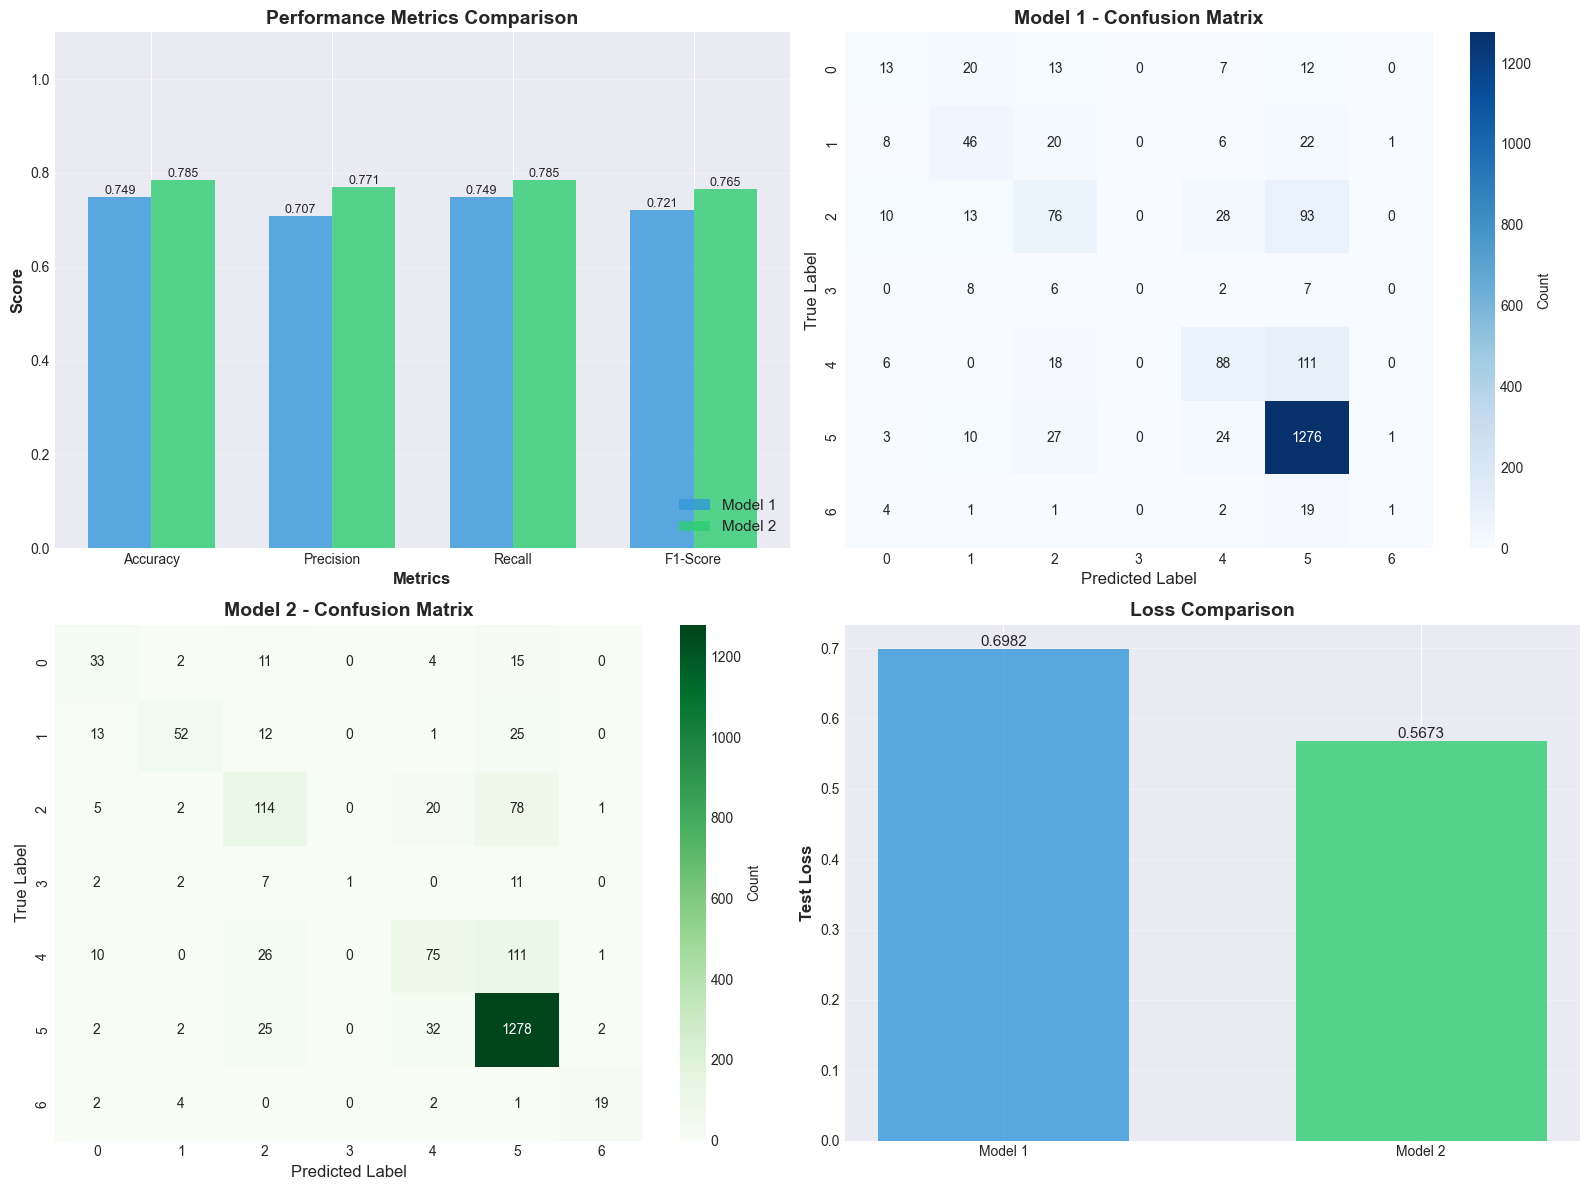

In [13]:
# ============================================================================
# CELL 8: Create Visualizations
# ============================================================================

print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

plot_comparison(results1, results2, "Model 1", "Model 2") 

In [14]:
# ============================================================================
# CELL 9: Final Recommendation
# ============================================================================

print_final_recommendation(results1, results2)

print("\n✅ COMPARISON COMPLETE!")
print("  - Detailed results printed above")
print("  - Visualization saved as 'model_comparison.png'")
print("="*60)


🎯 FINAL COMPARISON & RECOMMENDATION

Model 1 Accuracy: 0.7489 (74.89%)
Model 2 Accuracy: 0.7848 (78.48%)

✓ Model 2 has better accuracy by 3.59%

------------------------------------------------------------
💡 RECOMMENDATION: Model 2
------------------------------------------------------------


✅ COMPARISON COMPLETE!
  - Detailed results printed above
  - Visualization saved as 'model_comparison.png'


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_skin_cancer_model.h5")
model.save("skincanernew.keras", save_format="keras")
